#### Testing out Gibbs zig-zag code:

In [1]:
using Distributions, TimeIt, ProgressMeter, PyPlot

In [2]:
include("zz_structures.jl")
include("mbsampler.jl")

get_clustering (generic function with 1 method)

In [3]:
d, Nobs = 10, 100
p = 1e-1
X = sprandn(d, Nobs, 1e-1)
X[1,:] = ones(Nobs)
ξ_true = rand(Normal(),d).* rand(Binomial(1,0.5), d)
ξ_true[1] = rand(Normal())
y = [rand(Binomial(1, 1/(1+exp(-ξ_true'X[:,j]))), 1)[1] + 0. for j in 1:Nobs];
mb_size = 10
σ02 = 1

# prior = HS_prior(d, σ02)
# prior = GDP_prior(d, σ02)
prior = gaussian_prior_nh(zeros(d), 10*rand(d))

gaussian_prior_nh([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.93836, 3.72021, 3.16084, 7.06757, 4.336, 3.30845, 0.764458, 3.81191, 1.72218, 8.73632])

In [4]:
my_ll = ll_logistic_sp(X,y);
my_model = model(my_ll, prior)
root = find_root(my_model, rand(d));

In [14]:
# Sub-sampling with weights and with CV 

norm_Xj = [norm(X[:,j]) for j in 1:Nobs]
weights_het = spzeros(d, Nobs)
for i in 1:d 
    nz_ind = X[i,:].nzind
    weights_het[i,nz_ind] = abs.(X[i,nz_ind]).*norm_Xj[nz_ind] 
    weights_het[i,nz_ind] /= sum(weights_het[i,nz_ind])
end

prob_het = 1
mbs = Array{mbsampler}(d)
mbs[1] = umbsampler(Nobs, mb_size)
for i in 2:d 
    mbs[i] = spwumbsampler(Nobs, mb_size, weights_het[i,:], prob_het)
#     mbs[i] = umbsampler(Nobs, mb_size)
end
gs_list = cvmbsampler_list(my_model, mbs, root, true);

In [15]:
A = eye(d)

opf = projopf(A, 100, hyperparam_size(prior))
opt = maxa_opt(10^6)
outp = outputscheduler(opf,opt)
bb = linear_bound(my_model.ll, my_model.pr, gs_list)
update_bound(bb, my_ll, prior, gs_list, zz_state(opf));

In [16]:
print("Initial speed = ", opf.alpha_skeleton[:,opf.tcounter+1])

Initial speed = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [17]:
adapt_speed = true
L = 2
my_zz_sampler = zz_sampler(0, gs_list, bb, L, adapt_speed)
hyper_sampler = block_gibbs_sampler(1.)
blocksampler = Array{msampler}(2)
blocksampler[1] = my_zz_sampler
blocksampler[2] = hyper_sampler;

In [18]:
start = time()
ZZ_block_sample(my_model::model, outp::outputscheduler, blocksampler::Array{msampler})
print( round((time()-start)/60, 2), " mins")

10% attempts in 0.19 mins 
20% attempts in 0.38 mins 
30% attempts in 0.56 mins 
40% attempts in 0.75 mins 
50% attempts in 0.94 mins 
60% attempts in 1.12 mins 
70% attempts in 1.3 mins 
80% attempts in 1.48 mins 
90% attempts in 1.67 mins 
100% attempts in 1.85 mins 
1.85 mins

In [19]:
size(outp.opf.alpha_skeleton), size(outp.opf.xi_skeleton)

((10, 39784), (10, 39784))

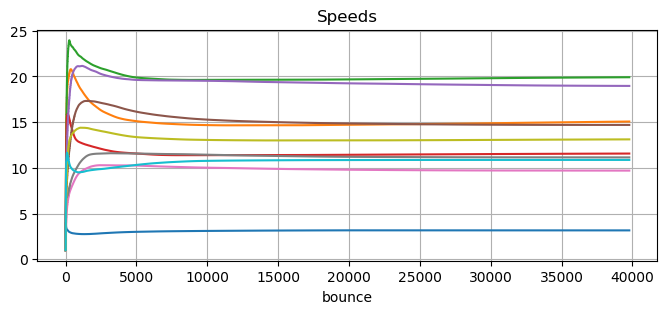

In [20]:
fig = figure("pyplot_barplot",figsize=(8,3))
for i in 1:d 
    plot((outp.opf.alpha_skeleton[i,:]))
end
title("Speeds")
xlabel("bounce")
grid(true)

In [21]:
discard = 1000
n_samples = 10^4
xi_samples = extract_samples(outp.opf.xi_skeleton[:,discard+1:end], 
                             outp.opf.bt_skeleton[:,discard+1:end], 
                             outp.opf.bt_skeleton[end]/n_samples,
                             "linear");
hyper_samples = extract_samples(outp.opf.hyper_skeleton[:,discard+1:end], 
                                outp.opf.bt_skeleton[:,discard+1:end], 
                                outp.opf.bt_skeleton[end]/n_samples, 
                                "constant");

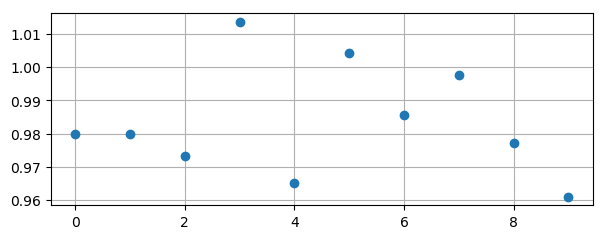

In [22]:
fig = figure("pyplot_barplot",figsize=(7,2.5))
plot([compute_configT(my_model, xi_samples[:,1:end-1], hyper_samples[:,1:end-1], k) for k in 1:d], "o")
grid(true)